# 이곳에서는
각 영화의 박스오피스 특징을 살펴본다  
특히 초반 흥행, 추반 입소문 영화를 구분하는데에 도전한다

이전 분석에서는 총 관객수와 총 상영주차, 상영횟수는 상관이 없었다.  
현재 분석에서는 총 관객수와 총 상영주차 두 데이터를 사용한다.  
그 이유는 2주차 까지의 데이터가 총 관객수와 큰 차이가 없을 경우 초반 흥행으로 판단할 수 있기 때문이다.  
따라서 최종 분석에서는 2주차 까지의 영화 패턴이랑 예측한 총 관객수 두개를 결합 비교해야 한다.  
총 상영주차는 총 관객수와 상관이 없으므로 예측 모델을 생성할 수 없었다. (그냥 지멋대로라고 생각한다)  
따라서 이거는 영화 데이터의 분포적 특성을 통해 파악할 수 있도록 한다. (이걸 통해 예측을 대체할 수 있을지도)

즉, 해당 분석에서 총 관객수는 사용해도 괜찮다. 최종 분석에서는 2주차 데이터 + 예측 총 관객수 데이터를 사용하기 때문이다 (물론 해당 모델의 신뢰도가 높아야 한다)  
따라서 총 상영주차는 분석의 재료로 사용되어서는 안된다. 분석의 대상이 되어야 한다.

# 라이브러리

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler

# 데이터

1만명 ~ 500만명 영화만 사용한다  
현재의 분석에선 배우, 감독 장르 벡터는 사용하지 않는다

In [120]:
data_train = pd.read_csv("../model/model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model/model_test_data.csv", encoding="utf-8-sig")
data_full = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

줄거리 임베딩 벡터는 사용하지 않는다

In [121]:
embedding_list = [f"e{i}" for i in range(1, 256+1)]
data_full.drop(columns=embedding_list, inplace=True)

In [122]:
data_full.drop(columns=["Total_Show_Days"], inplace=True)

In [123]:
pd.set_option('display.max_columns', None)
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,15세이상관람가,일본
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,전체관람가,기타


grade, main country 원핫인코딩

In [124]:
make_dummies_cols = ["Grade", "Main_Country"]
data_full = pd.get_dummies(data_full, columns=make_dummies_cols, drop_first=True)
one_hot_cols = [col for col in data_full.columns if col.startswith("Grade_") or col.startswith("Main_Country_")]
data_full[one_hot_cols] = data_full[one_hot_cols].astype("int8")
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,1,0,0,0,1,0
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0


In [125]:
movie_title = data_full[["Movie_Title"]].copy()
movie_data = data_full.drop(columns=["Movie_Title"]).copy()

# 관객수 비교

## 1) 1주차, 2주차, 최종 관람객 수 비교

In [126]:
temp1 = movie_data[["Total_Audience_Count", "wk1_Audience", "wk2_Audience"]].copy()
temp1.loc[:,"con_wk2"] = temp1["wk1_Audience"] + temp1["wk2_Audience"]
temp1.loc[:,"wk1_wk2"] = round((temp1["con_wk2"]/temp1["wk1_Audience"]-1)*100, 2)
temp1.loc[:,"wk2_total"] = round((temp1["Total_Audience_Count"]/temp1["con_wk2"]-1)*100, 2)

`wk1_wk2` : 1주차와 2주차의 관객수 변화율(백분율)  
`wk2_total` : 2주차와 총 관객수의 변화율(백분율)  

이제 이걸 통해 군집분석을 진행, 초반 흥행과 후반 흥행을 분류할 수 있는지 확인한다

In [127]:
cluster_1 = temp1[["wk1_wk2", "wk2_total"]]
cluster_1.describe()

,wk1_wk2,wk2_total
count,2568.000000,2568.000000
mean,75.819206,42.726908
std,51.384244,247.551834
min,2.730000,0.000000
25%,42.912500,6.485000
50%,64.820000,17.135000
75%,95.305000,42.582500
max,718.180000,11595.360000


이상치 제거

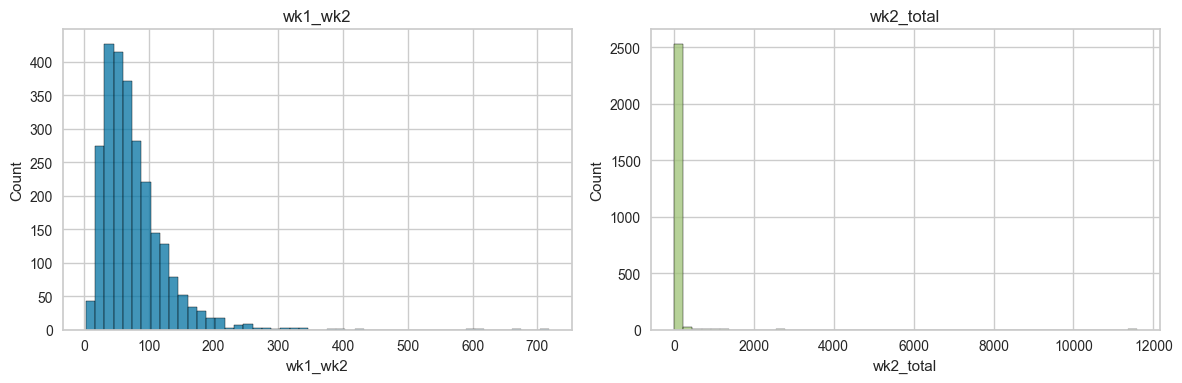

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(cluster_1["wk1_wk2"].dropna(), bins=50, ax=axes[0], color="C0")
axes[0].set_title("wk1_wk2")

sns.histplot(cluster_1["wk2_total"].dropna(), bins=50, ax=axes[1], color="C1")
axes[1].set_title("wk2_total")

plt.tight_layout()
plt.show()

In [129]:
# scaler = StandardScaler()
# cluster_1.loc[:,:] = scaler.fit_transform(cluster_1)
# cluster_1.describe()